In [1]:
import json
import numpy as np
import random
from tqdm import tqdm
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.decomposition import PCA
import re
import matplotlib.pyplot as plt
import sklearn

In [2]:
def rand_emot():
    e = ["(o_o)",":-)",":P",":D","x)","ᓚᘏᗢ","╯°□°）╯︵ ┻━┻",":)",
         "*<:-)","^_^","(⌐■_■)","¯\_(ツ)_/¯", "(T_T)",":o","OwO",
        "( ͡❛ ͜ʖ ͡❛)","(̶◉͛‿◉̶)","( ≖.≖)","(ㆆ_ㆆ)","ʕ•́ᴥ•̀ʔっ","( ◡́.◡̀)","(^◡^ )"]
    return random.choice(e)

def load_files():
    text_pairs = [] #Would be nice to have as np.array
    labels = []
    fandom = []
    
    pair_id = []
    true_id = []
    
    #Load truth JSON
    for line in open('data/modified/train_truth.jsonl'):
        d = json.loads(line.strip())
        labels.append(int(d['same']))
        true_id.append(d['id'])

    #Load actual fanfic.
    print("loading fanfic...",rand_emot())
    for line in tqdm(open('data/modified/train_pair.jsonl')):
        d = json.loads(line.strip())
        text_pairs.append(d['pair'])
        fandom.append(d['fandoms'])
        pair_id.append(d['id'])

    print("done loading",rand_emot())
    
    return text_pairs, labels, fandom, pair_id, true_id

In [3]:
text_pairs, labels, fandom, pair_id, true_id = load_files()

332it [00:00, 1663.27it/s]

loading fanfic... *<:-)


1578it [00:00, 1747.31it/s]

done loading ( ≖.≖)


In [4]:
def word_freq(text_pair):
    fdist0 = nltk.FreqDist(text_pair[0])
    fdist1 = nltk.FreqDist(text_pair[1])
    
    return [fdist0, fdist1]

def word_freq_single(text):
    fdist = nltk.FreqDist(text)
    return fdist

def tokenize(text_pair):
    return [nltk.word_tokenize(text_pair[0]),nltk.word_tokenize(text_pair[1])]

def vector_freq_dist(freq_dists): #I don't think this works...
    return [list(freq_dists[0].values()), list(freq_dists[1].values())]

def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [5]:
def create_corpus(text_pairs):
    '''input all text pairs to create a corpus'''
    corpus = [x[i] for x in text_pairs for i in range(len(x))]
    return corpus

def fit_tfidf(corpus):
    vectorizer = TfidfVectorizer()
    print("training vectorizer...",rand_emot())
    X = vectorizer.fit_transform(corpus)
    print("vectorizer fit!", rand_emot())
    
    
    df = pd.DataFrame(X[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
    df = df.sort_values('TF-IDF', ascending=False)
    
    return X, df

In [6]:
corpus = create_corpus(text_pairs)

In [7]:
#tf-idf on the raw text. Likely not useful, as you can see, it is sesnitive to the fandom.
raw_tfidf, tfidf_df = fit_tfidf(corpus)

training vectorizer... (T_T)
vectorizer fit! :D


In [8]:
tfidf_df.head(10)

,TF-IDF
the,0.389299
to,0.295670
kuroko,0.283424
judgement,0.247891
was,0.184794
and,0.182388
it,0.182330
that,0.172474
she,0.169618
her,0.146488


In [9]:
#Attempting to perform tf-idf on only symbols.
def isolate_symbols(corpus):
    #Add \d to omit digits too.
    sym_corpus = []
    for text in corpus:
        sym_corpus.append(' '.join(re.findall("[^a-zA-Z\s]+", text)))
    return sym_corpus

symbols = isolate_symbols(corpus)

#Okay, tf-idf doesn't work with symbols. I'll convert them to made-up words

In [10]:
symbols[0]

'. " , . , , . . " . " ?! ?! , - !" , . " . . - ." . , . , . , . - - . " . , . , , . ... , . , . , . " , . , . " " . " , " . " , - , " . ". ? , ." , . , , , ... ... . " . , " . , ?" , " . , . " , , " . ... . " . , . , " . , ? , " ! ?" , . , , . " ..." , . "... ! , ? , " " . , . ... !" , . " ? ." , , . , ... , . . " , ?" , " . " -! , . " , , -!" . . - . . " , . " " , . , . " . " , " . , . " , " . , " - . - . ... . " ... " . , , . , , - , . , . , . , , " . , , . . " - . ?! ?!" . . " , . , " , " . ... ? , " . " - . ?! ?!" . , . ... . , , . ... . " , . , , - . , , - - . , , , . , . - " , . " . , , ? ?" , , " . " , " . , . , ." , . , , . , , , . , . , , " . " . " , ? , " ." . " " ", " . " !" " . " , ? " - ? ?" . ... " " . , . , - , " " . " - , !" "... , ?" . . , . ... " . ... " ? "... , . , " ." " " !" - , . " . " , , . " - " . " . , , " . , , - " ", " . , " , " " . " . , . " , . . " , . . " " !" , . , . "... ?" , . " ... , . . " ... " ! , ! !" "... . , " , ?" . " , " . . " . , . " ... " " 

In [11]:
#Whack function that converts symbols to letters...
def symbol2word(symbols):
    '''Takes in set of symbols and convert them to unique words'''
    symbols = list(symbols)
    sym2word = {}
    chars = [0,0,0]
    
    for i in range(len(symbols)):
        chars[2] = add_one(chars[2])
        
        if chars[2] % 58 == 0:
            chars[1] = add_one(chars[1])
            chars[2] = 0
        
        if chars[1] % 58 == 0 and chars[1] != 0:
            chars[0] = add_one(chars[0])
            chars[1] = 0
        
        
        sym2word[symbols[i]] = 'XX'+chr(chars[0]+65)+chr(chars[1]+65)+chr(chars[2]+65)
    
    return sym2word

def add_one(x):
    if x == 91-66:
        return x + 7
    return x + 1

def replace_symbols(symwords, corpus):
    for i, text in tqdm(enumerate(corpus)):
        text = nltk.word_tokenize(text)
        text = replace(text, symwords)
        corpus[i] = text
    return corpus

def replace(tokens, dictionary):
    return [dictionary.get(item, item) for item in tokens]

def chunk_replace(corpus):
    start = 0
    for i in range(0,int(len(corpus)/100),100):
        corpus[start:i] = replace_symbols(symwords, corpus[start:i])
        start = i
    corpus[start:] = replace_symbols(symwords, corpus[start:])
    
    return corpus

In [12]:
#Convert symbols to words
symwords = symbol2word(set(symbols))

#DESTROY corpus by replacing symbols with their word.
#corpus = replace_symbols(symwords, corpus)

In [13]:
#print("joining corpus...",rand_emot())
#tfidf_sym, sym_df = fit_tfidf([' '.join(x) for x in corpus])

joining corpus... (̶◉͛‿◉̶)
training vectorizer... *<:-)


ValueError: empty vocabulary; perhaps the documents only contain stop words

In [14]:
#sym_df.head(10)

NameError: name 'sym_df' is not defined

In [16]:
key_list = list(symwords.keys())
val_list = list(symwords.values())

key_list[val_list.index('XXADM')], key_list[val_list.index('XXAAE')]

('" ." . " " ," , . . , . , " . . , , . , . . " " ," " . . " ." " " ." . " ." / : . " ! , " . , . . , . , , . , . " ," . , . , . " ?" , . . " , ," . " ." " ?" , . . " " ," , . " 3 . ." " ?" , . , . " , ." . " " ." " , " !" . " " . " . . , , . , , , . - , . " !" . " " ," . . . " , ? " ?" . " ." . " ?" , . . " ! " !" . " " " !" . " ," , . , . " ?" . " ," . " ." " . . . , . . " ," . " ." . " " . . ." . " " , . . . . ." " . . ... " ." " ..." . " ." . . . " ?" . " ! " . " ." " " , . ." . . , . . " " ! ! ." , . , . . , . . . . . , . . , . , , , . . " . " ," . " ," . " ?" " . . " . " ." . , . " . , , . , . . " ?" . , . " ." " ." " , . ." . " . , ." " ?" , . " , " ." " ?" , . . , . " ," . . " ," . . , . . , . , , , " . , ... , . * * / : . ! . , , . , . . , . . , . . . . . , . , . " ?" . . , . . , , . " , . , . " " !" . , . . , . , . . , . , , . " , , . , 12 , . , . , . , . , . " , ." - . , . . " , ," - , . " " ." , - . , . " " ," . - , . " , . , ." " ?" , . " " , . . ." " ?" " , , . , . ." " !

In [17]:
## POS Tagging and ngrams
tokens = nltk.word_tokenize(corpus[0])
pos_tags = nltk.pos_tag(tokens)
pos_bigrams = nltk.bigrams(pos_tags)

In [18]:
def compute_lix(text):
    tokens = nltk.word_tokenize(text)
    splt = text.split()
    o = len(splt)+1
    p = len([x for x in tokens if x=='.'])+1
    l = len([x for x in tokens if len(x)>6])+1
    
    return (o/p)+((l*100)/o)

In [19]:
for text in corpus[:10]:
    print(compute_lix(text))

29.910954831914932
30.709476503232075
34.64747315241397
31.16576505295295
35.736950980754315
27.826830313919487
23.657931484369428
30.435502148277408
29.67444070920108
27.62315961549868


In [20]:
def tokenize_no_symbols(text):
    return nltk.word_tokenize(re.sub(r'[^\w]', ' ', text))

def get_fdist_yule(text):
    text = tokenize_no_symbols(text)
    fdist = word_freq_single(text)
    return fdist
        
def get_num_unique_words(text):
    text = tokenize_no_symbols(text.lower())
    return len(set(text))
        
def yules_k(text): #Wrong implementation, forget this function.
    C = 10000
    splt = text.split()
    N = len(splt)
    Vn = get_num_unique_words(text)
    fdist = get_fdist_yule(text)
    max_word = fdist.most_common()[0][1]
    
    var = 0
    
    for m in range(max_word):
        Vmn = len([x for x in fdist if fdist[x]==m])
        mNs = np.power(m/N,2)
        
        var += Vmn*mNs
    
    return C*(-1/N+var)


#Stolen code below
import collections
import re

def tokenize(s):
    tokens = re.split(r"[^0-9A-Za-z\-'_]+", s)
    return tokens

def get_yules(s):
    """ 
    Returns a tuple with Yule's K and Yule's I.
    (cf. Oakes, M.P. 1998. Statistics for Corpus Linguistics.
    International Journal of Applied Linguistics, Vol 10 Issue 2)
    In production this needs exception handling.
    """
    tokens = tokenize(s)
    token_counter = collections.Counter(tok.upper() for tok in tokens)
    m1 = sum(token_counter.values())
    m2 = sum([freq ** 2 for freq in token_counter.values()])
    i = (m1*m1) / (m2-m1)
    k = 1/i * 10000
    #The larger the K, the easier the text
    #The larger the I, the more difficult text
    #Both measure vocabulary richness
    return (k, i)

#Cite the function: https://gist.github.com/magnusnissel/d9521cb78b9ae0b2c7d6

In [21]:
#I am not 100% sure I implemented Yule's K the right way.


In [22]:
#We can also use CountVectorizer
c_vec = CountVectorizer()
cX = c_vec.fit_transform(corpus)
cX.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [23]:
#Hmmm... 
tfidf_vec = TfidfVectorizer()
tfidfX = tfidf_vec.fit_transform(corpus)
tfidfX.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
logreg = LogisticRegression(max_iter=1000)
cx_arr = cX.toarray()
cvec_pairs = [np.concatenate([cx_arr[x],cx_arr[x+1]]) for x in range(0,len(cx_arr),2)]

cvec_train, cvec_test, labels_train, labels_test = train_test_split(cvec_pairs, labels)
len(cvec_train)

1183

In [25]:
#Slow!
logreg.fit(cvec_train, labels_train)

LogisticRegression(max_iter=1000)

In [26]:
#62% accuracy just from word freq on raw text.
logreg.score(cvec_test, labels_test)

0.6329113924050633

In [27]:
tfidf_arr = tfidfX.toarray()
tfidf_pairs = [np.concatenate([tfidf_arr[x],tfidf_arr[x+1]]) for x in range(0,len(tfidf_arr),2)]

tf_train, tf_test, tf_labels_train, tf_labels_test = train_test_split(tfidf_pairs, labels)
len(tf_train)

1183

In [28]:
#64% accuracy on tfidf on raw text.
logreg.fit(tf_train, tf_labels_train)
logreg.score(tf_test, tf_labels_test)

0.6050632911392405

In [29]:
#BAD result!
logreg.fit(np.hstack([tf_train,cvec_train]), tf_labels_train)
logreg.score(np.hstack([tf_test,cvec_test]), tf_labels_test)

0.5037974683544304

In [30]:
tfsym_arr = tfidfX.toarray()
tfsym_pairs = [np.concatenate([tfsym_arr[x],tfsym_arr[x+1]]) for x in range(0,len(tfsym_arr),2)]

tfsym_train, tfsym_test, tfsym_labels_train, tfsym_labels_test = train_test_split(tfsym_pairs, labels)

In [31]:
#61% 
logreg.fit(tfsym_train, tfsym_labels_train)
logreg.score(tfsym_test, tfsym_labels_test)

0.5848101265822785

In [32]:
lix_vec = np.array([compute_lix(x) for x in corpus])
yule_vec = np.array([yules_k(x) for x in corpus])

In [33]:
lix_pairs = [np.hstack([lix_vec[x],lix_vec[x+1]]) for x in range(0,len(lix_vec),2)]
lix_train, lix_test, lix_labels_train, lix_labels_test = train_test_split(lix_pairs, labels)

yule_pairs = [np.hstack([yule_vec[x],yule_vec[x+1]]) for x in range(0,len(yule_vec),2)]
yule_train, yule_test, yule_labels_train, yule_labels_test = train_test_split()

ValueError: At least one array required as input

In [ ]:
logreg.fit(lix_train, lix_labels_train)
logreg.score(lix_test, lix_labels_test)

In [34]:
def plot_pcs(pcs, target, labels, ctitle=""):   
    group1 = pcs[target==0]
    group2 = pcs[target==1]
    
    plt.scatter(group1[:,0], group1[:,1], cmap='jet', label=labels[0], s=8)
    plt.scatter(group2[:,0], group2[:,1], cmap='jet', label=labels[1], s=2)
    
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend(loc="best")
    plt.title(ctitle)

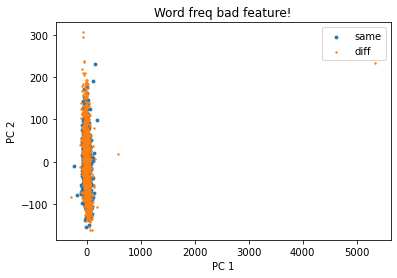

In [35]:
pca = PCA(n_components=2)
cx_arr = cX.toarray()
cvec_pairs = [np.concatenate([cx_arr[x],cx_arr[x+1]]) for x in range(0,len(cx_arr),2)]

pcs = pca.fit_transform(cvec_pairs)

plot_pcs(pcs, np.array(labels), ("same", "diff"), ctitle="Word freq bad feature!")

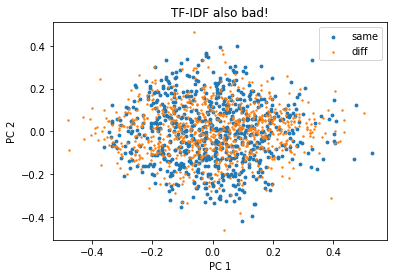

In [36]:
tf_pcs = pca.fit_transform(tfidf_pairs)
plot_pcs(tf_pcs, np.array(labels), ("same", "diff"), ctitle="TF-IDF also bad!")

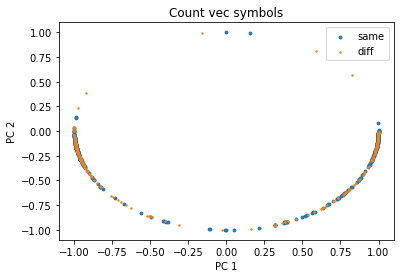

In [37]:
sym_countvec = CountVectorizer()
sym_arr = sym_countvec.fit_transform(symbols).toarray()

sym_pairs = [np.concatenate([sym_arr[x],sym_arr[x+1]]) for x in range(0,len(sym_arr),2)]

sym_pcs = pca.fit_transform(sym_pairs)
plot_pcs(sklearn.preprocessing.normalize(sym_pcs), np.array(labels), ("same", "diff"), ctitle="Count vec symbols")

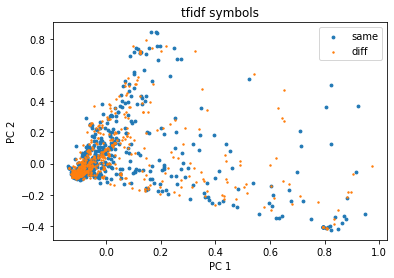

In [38]:
sym_countvec = TfidfVectorizer()
sym_arr = sym_countvec.fit_transform(symbols).toarray()

sym_pairs = [np.concatenate([sym_arr[x],sym_arr[x+1]]) for x in range(0,len(sym_arr),2)]

sym_pcs = pca.fit_transform(sym_pairs)
plot_pcs(sym_pcs, np.array(labels), ("same", "diff"), ctitle="tfidf symbols")

In [39]:
cos_sym_pairs = np.array([cosine_sim(x,x+1) for x in range(0,len(sym_arr),2)])
                         #Hmmm

sym_pcs = pca.fit_transform(cos_sym_pairs)
#plot_pcs(sym_pcs, np.array(labels), ("same", "diff"), ctitle="cosine tfidf symbols")

c:\python37\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


ValueError: Expected 2D array, got 1D array instead:
array=[nan  1.  1. ...  1.  1.  1.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [40]:
def remove_symbols(text):
    sentences = re.split('[\.+|!|?]', text)
    sentences = [re.sub(r"[^\w]+", ' ', x) for x in sentences if len(x.strip()) != 0]
    return ' '.join(sentences)

def get_sent_word_length(text):
    #Function, which removes symbols and count words in sentence
    #Output: length of each sentence & length of each word
    sentences = re.split('[\.+|!|?]', text)
    sentences = [re.sub(r"[^\w]+", ' ', x) for x in sentences if len(x.strip()) != 0]
    word_sentences = [nltk.word_tokenize(x) for x in sentences]
    sentence_lengths = np.array([len(x) for x in word_sentences])
    word_lengths = np.array([len(s) for x in word_sentences for s in x])
    return sentence_lengths, word_lengths

get_sent_word_length(corpus[0])

(array([ 7, 10, 17,  7, 13,  3,  3, 10, 20,  2,  7,  4,  3, 13, 16, 17, 27,
         6, 13, 20,  1, 22, 20, 15, 14, 12,  7, 14, 15,  7,  1,  9, 15, 21,
         5,  2, 14,  3, 23,  8, 11,  1,  6, 12,  9,  8,  8,  3,  9, 14,  1,
         8,  0,  2,  3, 14,  6,  2,  3,  8,  2,  2, 12,  9, 15,  2, 17, 17,
         4, 14,  8,  7, 23, 11,  3, 18, 23,  6,  7, 23, 24, 34, 10,  2,  2,
        12,  2,  5, 11, 14,  4, 12, 16, 17, 12,  2,  3,  3,  2,  6, 24, 26,
         1,  3, 23,  2,  3,  3,  2, 26,  2,  5, 23,  3,  7, 15, 29, 22, 25,
        11,  4, 10,  8,  4, 33,  5,  7,  7,  8, 20, 27, 15, 18, 13, 10, 12,
         4, 13, 17, 11,  2, 13,  9,  2,  5, 11, 20, 29, 19,  0,  3,  2,  4,
        14,  1,  9,  3,  8,  0,  2,  8,  5, 19,  8, 17, 21, 17, 16, 21, 26,
         9,  5, 32,  6, 13, 15,  3, 17, 29,  0,  4, 10,  1,  7,  3,  2,  4,
        13,  5,  0,  1, 14,  3, 24, 10,  1,  3,  2, 18,  1,  4,  2, 18,  5,
        25,  2,  5,  4,  2, 25,  8,  1,  8,  5,  6, 10,  2,  1,  2, 10, 19,
         0, 

http://norvig.com/spell-correct.html - Spelling correction

In [41]:
from spellchecker import SpellChecker

def misspelled_words(text):
    #Library for spell checking
    spell = SpellChecker()
    text = remove_symbols(text)
    #Regex for finding digits
    _digits = re.compile('\d')

    #List of misspelled words
    misspelled = spell.unknown(text.split())
    #Remove words, that start with capital letter (Likely names)
    no_names = [x for x in misspelled if x.title() not in text]
    #Remove words that contain digits (7th)
    no_digits = [x for x in no_names if not bool(_digits.search(x))]
    
    #Find corrections for misspelled words - if word is more than a single character.
    corrections = [spell.correction(x) for x in no_digits if len(x)>1]
    #Remove corrections, if they have no correction (likely misclassified spelling mistake)
    remove_no_correction = [x for x in corrections if x not in misspelled]
    return remove_no_correction

misspelled_words(corpus[1])

['peace',
 'fastball',
 'herface',
 'cancer',
 'cooked',
 'all',
 'capulets',
 'tad',
 'sis',
 'encompass',
 'rank',
 'ooh',
 'default',
 'pandora',
 'voiceover',
 'la',
 'nonstop',
 'dizzy',
 'he',
 'mortys',
 'alive',
 'threatened',
 'ranks']

In [42]:
import scipy
def show_me_pca(vector, labels, is_pairs=False, title=""):
    '''Plot PCA for the two classes. Input is one long vector/list, it creates pairs itself.
    If you already created pairs, use is_pairs=True
    Example: if vector is distance between pairs, do not set is_pairs to True. 
    (as it is one vector describing both documents.)
    
    labels is simply a vector with the labels, which will be used to colour the scatter plot.'''
    
    #Convert labels to np.array (might be a list.)
    labels = np.array(labels)
    
    #Join pairs into one, long vector if necessary. 
    if not is_pairs:
        vector = [np.hstack([vector[x],vector[x+1]]) for x in range(0,len(vector),2)]  
    
    #Get that PCA - Use SVD if vector is sparse.
    if scipy.sparse.issparse(vector):
        pca = TruncatedSVD(n_components=2)
    else:
        pca = PCA(n_components=2)
    pcs = pca.fit_transform(vector)
    
    #Printing pcs shape - remember they might be halved, due to pairing. 
    print(pcs.shape)
    
    #Group PC's into two, according to label indices. 
    group1 = pcs[labels==0]
    group2 = pcs[labels==1]
    
    #Plot that shit!
    plt.scatter(group1[:,0], group1[:,1], s=5)
    plt.scatter(group2[:,0], group2[:,1], s=5)
    plt.title(title)

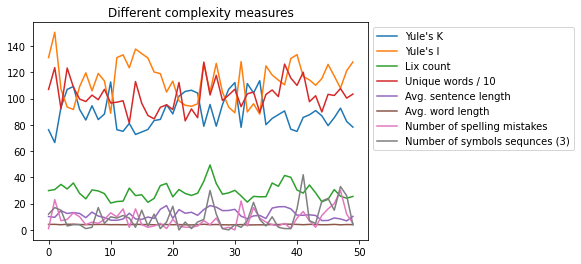

In [43]:
#Pretty slow
k_list = []
i_list = []
lix_list = []
unique_list = []
avg_sent_len_list = []
avg_word_len_list = []
num_of_spelling_mistakes = []
num_of_symbol_sequences = []
for i, text in enumerate(corpus[:50]):
    k_list.append(get_yules(text)[0])
    i_list.append(get_yules(text)[1])
    lix_list.append(compute_lix(text))
    unique_list.append(get_num_unique_words(text)/10)
    sent_word = get_sent_word_length(text)
    avg_sent_len_list.append(np.mean(sent_word[0]))
    avg_word_len_list.append(np.mean(sent_word[1]))
    num_of_spelling_mistakes.append(len(misspelled_words(text)))
    num_of_symbol_sequences.append(len([x for x in symbols[i].split() if len(x)>3]))
    

plt.plot(k_list, label="Yule's K")
plt.plot(i_list, label="Yule's I")
plt.plot(lix_list, label="Lix count")
plt.plot(unique_list, label="Unique words / 10")
plt.plot(avg_sent_len_list, label="Avg. sentence length")
plt.plot(avg_word_len_list, label="Avg. word length")
plt.plot(num_of_spelling_mistakes, label="Number of spelling mistakes")
plt.plot(num_of_symbol_sequences, label="Number of symbols sequnces (3)")
plt.title("Different complexity measures")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.rcParams["figure.figsize"] = (20, 10)
plt.show()

(50, 2)


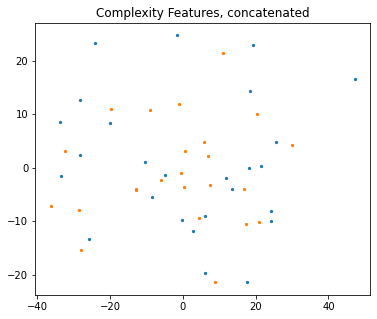

In [44]:
#Create one numpy array from of lists of features
def create_feature_vectors(lists):
    return np.vstack(lists).T

feat_vec1 = create_feature_vectors([k_list, i_list, lix_list, unique_list, avg_sent_len_list, 
                                    avg_word_len_list,num_of_spelling_mistakes, num_of_symbol_sequences])

plt.rcParams["figure.figsize"] = (6, 5)
show_me_pca(feat_vec1, labels[:50], is_pairs=True, title="Complexity Features, concatenated")

(25, 2)


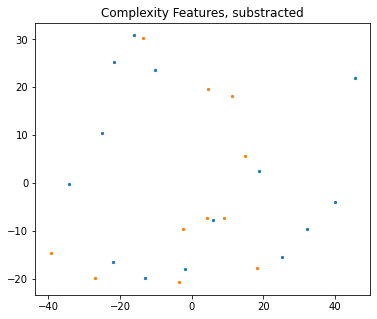

In [45]:
feat_vec2 = [feat_vec1[x]-feat_vec1[x+1] for x in range(0,len(k_list),2)]
show_me_pca(feat_vec1, labels[:25], title="Complexity Features, substracted")

In [46]:
tokens = nltk.word_tokenize(corpus[0])
pos_tags = nltk.pos_tag(tokens)
pos_bigrams = nltk.bigrams([x[1] for x in pos_tags])


pos_bigrams = list(pos_bigrams)
pos_fdist = nltk.FreqDist(pos_bigrams)
count_vec = CountVectorizer()
X = count_vec.fit_transform([' '.join(x) for x in pos_bigrams])

In [47]:
X.toarray().shape

(4810, 29)

In [ ]:
' '.join(pos_bigrams[0])